## Webscraping discussion threads on lawforum.co.uk

As part of the cross-Government Social Media Research Group's hackathon, run on 7th July at Microsoft's UK headquarters in Reading, I webscraped [lawforum.co.uk](http://www.thelawforum.co.uk/forums/general-chat)'s discussion threads. This was part of one of the hackathon's topic areas, to explore how social media is used to help people deal with justice problems, particularly employment justice problems.

There are three aims to this short piece of analysis:
* Demonstrate how social media analysis can be used to help understand people's approaches to solving justice problems
* Explore where the prevalence of discussions around employment justice problems lie on lawforum.com
* See what sort of discussions take place about employment justice problems on lawforum.com

This can be used as a framework when webscraping other forums for analysing how social media is used to solve justice problems.

This notebook details the code which can be used to carry out this analysis. It uses three technique areas:
* Webscraping
* Simple word counts
* Topic modelling - term frequency/inverse document frequency and Latent Dirichlet Algorithm

### Stage 1: Prepare coding environment

In [63]:
###First, import the Python modules required

%matplotlib inline 
#The above line plots graphs within this notebook and not in an external windows

import pandas as pd #A module to create dataframes
import requests #A module to send requests to websites
from lxml import html #A module to process website coding languages
import spacy #A module to process text
import string #A module to process text
import nltk #A module to process text
from nltk.corpus import stopwords #A module to process text
from nltk.tokenize import sent_tokenize, word_tokenize #A module to process text
from collections import Counter #A module to count the frequency of words
import matplotlib.pyplot as plt #A module for plotting graphs
import numpy as np #A module to perform numerical analysis
from datetime import datetime #A module to convert times
import sys
reload(sys)  
import json #A module for writing JSON files
sys.setdefaultencoding('utf8')

In [64]:
###Second, create some functions to do text mining

#This line details where the libraries used for text mining are located - this path will need to be changed 
#for other computers
nltk.data.path.append('/Users/callumstaff/Documents/Analysis/nltk_data/')

#This function performs lemmatisation - turning words into their root word (e.g. plays to play, dogs to dog)
#Note: lemmatisation often removes the 'e' off words - e.g. advice to advic
wnl = nltk.WordNetLemmatizer()
def lemmat_func(x):
    my_string_split = str.split(x)
    my_string_lemmat = map(wnl.lemmatize, my_string_split)
    my_string = ' '.join(my_string_lemmat)
    return my_string

#This function performs stemming - similar to lemmatisation, turns words back to their 'stem' (e.g. playing to play)
stem_func = nltk.PorterStemmer()
def stemming_func(x):
    my_string_split = str.split(x)
    my_string_stem = map(stem_func.stem, my_string_split)
    my_string = ' '.join(my_string_stem)
    return my_string

#This function removes stopwords - typically small words that appear frequently given their use (e.g. a, the, how)
def stopwords_func(x):
    stopWords = set(stopwords.words('english'))
    my_string_split = word_tokenize(x)
    my_string = []
    for w in my_string_split:
        if w not in stopWords:
            my_string.append(w)
    my_string = ' '.join(my_string)
    return my_string

### Webscraping

If you go to lawforum.co.uk you will see the threads are 'pagenated' (distributed over a number of pages). The first page's URL is found in the code below, the variable `base_url`. The other pages follow the format of the variable `url_pagenate` - at the end of `url_pagenate` is `%d`, which is used in subsequent code to cycle through each of the pages, from page 2 to page 36.

To locate the correct elements in the webpage to scrape we will use Xpaths - visit [w3schools.com](http://www.w3schools.com) for more information on Xpaths.

We will scrape the title of the thread, and the URL to the thread itself. The latter will be used to access that page and scrape the comments in it.

In [65]:
#Define the URLs which we will scrape
url_base = 'http://www.thelawforum.co.uk/forums/general-chat'
url_pagenate = 'http://www.thelawforum.co.uk/forums/general-chat?page=%d'

The picture below shows the design of the webpage to be scraped, and the corresponding XHTML code, which will be used to build the XPath.

![](thelawforum.png)

You can see on the righthand side, the highlighted code, which corresponds to the element of the webpage relating to the thread. The XPath for the hyperlink is `//td/a/@href`. This means:
1. `//`: Any item which is a descendant of the root node (the very first element in the script to build this webpage
2. `td`: A standard cell within a table
3. `a`: An anchor element, used for links
4. `@href`: An attribute of the `a` element, which contains hyperlinks

So, this XPath says _within anywhere in the document, find me the values of the attribute `href` which sit within an anchor element which itself sits in a table cell.

The XPath for the thread title is the same for parts 1 to 3, except the fourth stage uses `text()` instead of `@href`. This `text()` part requests the text associated with the `href`.

In [66]:
### Scrape the first page using the base_url variable

#Create empty links to scrape the data into
links_list = []
titles_list = []

page = requests.get(url_base) #This sends a request to url_base and gets the contents of the webpage back
tree = html.fromstring(page.content) #This turns the contents of the webpage into a tree
links = tree.xpath('//td/a/@href') #This is the XPath for the hyperlink to each of the threads, detailed above
links = ['http://www.thelawforum.co.uk' + url for url in links] #This concatenates the hyperlink with the site url
title = tree.xpath('//td/a/text()') #This is the Xpath for the title of each thread, as detailed above
links_list = links_list + links #This adds each link to the empty list
titles_list = titles_list + title #This adds each title to the empty list

In [67]:
#This code scrapes the 2nd to 37th pages. It uses the same code as above, except applies it to a for loop, which
#places each number between 1 (the 2nd page) and 36 (the 37th page) in the %d of the url_pagenate variable
for url in [url_pagenate % i for i in range(1,37)]:
    page = requests.get(url)
    tree = html.fromstring(page.content)
    links = tree.xpath('//td/a/@href')
    links = ['http://www.thelawforum.co.uk' + url for url in links]
    title = tree.xpath('//td/a/text()')
    links_list = links_list + links
    titles_list = titles_list + title

### Data Manipulation

Here we tidy up the data to put it into a format which can be analysed. The first 10 rows of the dataframe are shown as an example below.

In [68]:
#This turns the webscraped data into a dataframe
Law_Forum_Issues = {"Issue": titles_list,"URL": links_list}
Law_Forum_Issues = pd.DataFrame(Law_Forum_Issues)
Law_Forum_Issues[0:9]

,Issue,URL
0,Financial Non-Disclosure,http://www.thelawforum.co.uk/financial-non-dis...
1,BENJAMIN B. CHILDS is a best lawyer in LAS VE...,http://www.thelawforum.co.uk/benjamin-b-childs...
2,Paintings of famous people,http://www.thelawforum.co.uk/paintings-famous-...
3,How do I estimate how long an employment tribu...,http://www.thelawforum.co.uk/how-do-i-estimate...
4,Still struggling with self-assessment?,http://www.thelawforum.co.uk/still-struggling-...
5,Contest Employment Tribunal Extension Request?,http://www.thelawforum.co.uk/contest-employmen...
6,UK Bribery Act,http://www.thelawforum.co.uk/uk-bribery-act-0
7,Caravan on 'private' land,http://www.thelawforum.co.uk/caravan-private-land
8,Share capital/shares,http://www.thelawforum.co.uk/share-capitalshares


In [70]:
#Remove all punctuation from the thread titles (this uses regular expressions)
Law_Forum_Issues['Issue'] = Law_Forum_Issues['Issue'].str.replace('[^\w\s]','')

In [71]:
#Turn all text to lower case
Law_Forum_Issues['Issue'] = Law_Forum_Issues['Issue'].str.lower()

The next bit of code highlights a problem with social media data: there are a number of threads advertising cheap kitchens or furniture, either from a spammer or a bot. The image below shows this, but they must be removed in order to process the data accurately.

![](cheapkitchens.png)
![](furniture.png)

In [72]:
#Remove threads which contain the string 'cheap kitchens' or 'furniture'
Law_Forum_Issues = Law_Forum_Issues[Law_Forum_Issues.Issue.str.contains("cheap kitchens|furniture") == False]

In [73]:
#Strings can be encoded in a certain way - this changes the format to one which can be processed with text mining
Law_Forum_Issues['Issue'] = Law_Forum_Issues['Issue'].apply(lambda x: x.encode('utf-8'))

### Text Mining

We will now use the functions defined at the top of the notebook to perform text mining.

In [74]:
#Code to download NTLK libraries
#These need only be run once
nltk.download("INSERT LIBRARY HERE", "INSERT PATH HERE/nltk_data/")

False

In [75]:
#Lemmatisation
Law_Forum_Issues['Issue2'] = Law_Forum_Issues['Issue'].apply(lambda x: lemmat_func(x))

#Stemming
Law_Forum_Issues['Issue2'] = Law_Forum_Issues['Issue2'].apply(lambda x: x.encode('utf-8'))
Law_Forum_Issues['Issue2'] = Law_Forum_Issues['Issue2'].apply(lambda x: stemming_func(x))

#Removing stopwords
Law_Forum_Issues['Issue2'] = Law_Forum_Issues['Issue2'].apply(lambda x: stopwords_func(x))

In [76]:
#Count the frequency of words within the titles and create a new dataframe
Word_Count = pd.DataFrame(Counter(" ".join(Law_Forum_Issues['Issue2']).split(" ")).items())

In [77]:
#Rename columns
Word_Count.columns = ['Word','Count']

In [78]:
#Remove the first line, which counts blanks
Word_Count = Word_Count.ix[1:]

In [79]:
#Order in descending order of frequency 
Word_Count = Word_Count.sort_values(by='Count',ascending=False)
Word_Count = pd.DataFrame(Word_Count)

In [80]:
#Remove some words which aren't stopwords but appear very frequently and aren't very insightful
#Also remove words which appear less than 20 times as they don't give insight
#The top 10 rows have been displayed
Word_Count = Word_Count[(Word_Count.Count < 70) & (Word_Count.Count > 20)]
Word_Count[0:9]

,Word,Count
333,employ,54
745,advic,52
926,legal,49
1128,court,46
331,properti,44
584,claim,43
769,cheap,40
1779,need,38
1585,pleas,37


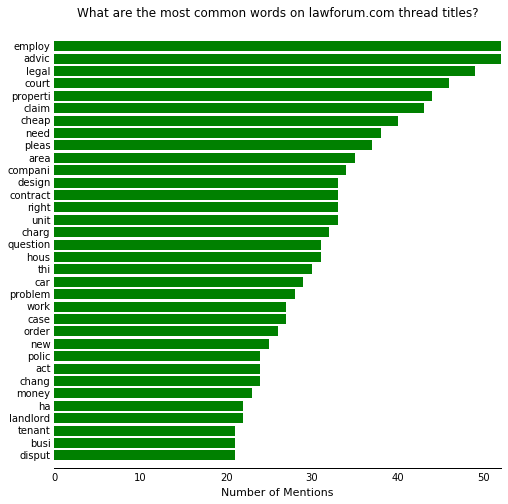

In [81]:
#Plot a graph to show the most frequent words
Word_Count = Word_Count.sort_values(by='Count',ascending=True)
plt.rc("figure", facecolor="white")
fig, ax = plt.subplots(figsize=(8,8))
y_pos = np.arange(len(Word_Count['Word']))

ax.barh(y_pos + 1, Word_Count['Count'], align='center', color='green',edgecolor = "none")
ax.set_yticks(y_pos+1)
ax.set_yticklabels(Word_Count['Word'], fontsize = 10)
ax.set_xlabel('Number of Mentions', fontsize = 11)
ax.set_title('What are the most common words on lawforum.com thread titles?')
ax.set_xlim([0,52])
ax.set_ylim([0,36])
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.tick_params(axis='x', which='major', labelsize=10)
plt.show()

We can see that the most frequent word is 'employ' - so it appears that the most frequent topic for discussion on the website are employment issues. A little further down we can also see 'properti' - the stem of property, and 'hous' - the stem of house, as well as landlord and tenant, suggesting that real estate justice issues are also a major area of focus.

## Webscraping comments

We will now scrape the comments from each of the threads. The data will contain:
* The URL
* The initial comment
* When the initial comment was posted
* Posts replying to the comment
* The time of the posts
* The legal expertise of the poster

In [98]:
len(Law_Forum_Issues)

1770

In [101]:
discussion_content = []
counter = 0
for url in Law_Forum_Issues['URL']:
    page = requests.get(url)
    tree = html.fromstring(page.content)
    try:
        time_posted = tree.xpath('//div/div/div/span/text()')
        time_posted = time_posted[0][-18:].replace("- ","")
        time_posted = time_posted.replace("/20","/")
    except(IndexError):
        time_posted = []
    #time_posted = datetime.strptime(time_posted,"%d/%m/%y %H:%M")
    init_post = tree.xpath('//div[contains(@class, "node")]/div[contains(@class, "content")]/p/text()')
    init_post = ''.join(init_post)
    init_post = init_post.replace(u"\xa0","")
    init_post = init_post.replace(u"\u201c",'"')
    init_post = init_post.replace(u"\u201d",'"')
    init_post = init_post.replace(u"\u2019","'")
    if init_post == u'':
        init_post = tree.xpath('//div[contains(@class, "node")]/div[contains(@class, "content")]/p/span/text()')
        init_post = ''.join(init_post)
        init_post = init_post.replace(u"\xa0"," ")
        init_post = init_post.replace(u"\u201c",'"')
        init_post = init_post.replace(u"\u201d",'"')
        init_post = init_post.replace(u"\u2019","'")
    discussion_posts = []
    count_posts = tree.xpath('count(//div[contains(@class, "comment")]/div[contains(@class, "content")])')
    num = 1
    while num < count_posts+1:
        post_xpath = '//div[contains(@class, "comment")][%d]/div[contains(@class, "content")]//text()' % num
        post = tree.xpath(post_xpath)
        post = post[::2]
        post = ' '.join(post)
        post = post.replace(u"\xa0"," ")
        post
        num += 1
        discussion_posts.append(post)
    num = 1
    post_date_xpath = '//div[contains(@class, "submitted")]/text()'
    post_dates = tree.xpath(post_date_xpath)
    post_dates = [post_date[-19:-1] for post_date in post_dates]
    post_dates = [post_date.replace("- ","") for post_date in post_dates]
    post_dates = [post_date.replace("/20","/") for post_date in post_dates]
    #post_dates = [datetime.strptime(post_date,"%d/%m/%y %H:%M") for post_date in post_dates]
    if len(discussion_posts) == 0:
        discussion_posts = ''
    if len(post_dates) == 0:
        post_dates = ''
    thread = {"1.Init_Post": init_post,
             "2.Time_Posted": time_posted,
             "3.URL": url,
             "4.Discussion_Posts": discussion_posts,
             "5.Discussion_Post_Times": post_dates}

    thread['4.Discussion'] = [
        {'a.Discussion_Post':i[0], 'b.Discussion_Post_Time':i[1]} 
        for i in zip(thread['4.Discussion_Posts'], thread['5.Discussion_Post_Times'])
    ]
    del thread['4.Discussion_Posts']
    del thread['5.Discussion_Post_Times']
    
    discussion_content.append(thread)
    
    counter +=1
    print(counter)
    
discussion_content

[{'1.Init_Post': u'I have recently come to learn that my ex - husband failed to declare a second pension during our divorce proceedings!',
  '2.Time_Posted': '08/08/17 22:53',
  '3.URL': 'http://www.thelawforum.co.uk/financial-non-disclosure',
  '4.Discussion': [{'a.Discussion_Post': u'I have collated as much evidence as I can. Divorce proceeding cost \xa347,000 and I need to know if It is worth taking this back to court. I have no wish to use the same solicitors and would appreciate any reccommendations.  ',
    'b.Discussion_Post_Time': '08/08/17 22:55'},
   {'a.Discussion_Post': u'Hi I need to know more before advising. Do you know the approximate value of the second undeclared pension? How long ago was it approximately since the final financial order was made by the divorce court? How has this second pension now come to your attention?  ',
    'b.Discussion_Post_Time': '07/09/17 17:13'},
   {'a.Discussion_Post': u'Hi    The 2nd firm of income was a veterans/disability payment which

In [102]:
with open('law_forum_scrape.json', 'w') as f:
     json.dump(discussion_content, f)